# EDA & Topic Modeling

# **Team 011**

#### Members: Ayush Trivedi, Dheeraj Pamnani, Dominic Darrah, Riya Agarwal, Sravani Bolla

# **Executive Summary:**
We aim to analyze restaurant reviews to identify key words and themes that contribute to positive or negative star ratings. Additionally, we seek to explore the relationship between reviews, tipping behavior, and overall ratings to better understand what drives customer generosity and satisfaction. Our focus will be on restaurants in Florida (FL) and Pennsylvania (PA), comparing trends across states to determine consistency in customer feedback. We are considering only restaurants with cuisines - American, Chinese and Italian. This analysis will provide restaurant owners with valuable insights to improve marketing strategies and enhance customer satisfaction.


# **Data Sources:**
- Review Dataset, Business Dataset, User Dataset, Tip Dataset
- State filtering (considering only states PA and FL), Category filtering (Considering categories of restaurant that serve American, Chinese, Italian and Thai cuisine)

## Description:

- Yelp Dataset: A collection of business, review, and user data from Yelp, which is widely used for sentiment analysis, recommendation systems, and text mining.

## Link of the Dataset:
https://business.yelp.com/data/resources/open-dataset/

## Importing Necessary Libraries and the Datasets

In [1]:
!pip install  boto3==1.28.57 botocore==1.31.57

  Using cached botocore-1.31.57-py3-none-any.whl.metadata (6.0 kB)
Using cached botocore-1.31.57-py3-none-any.whl (11.2 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.17
    Uninstalling botocore-1.31.17:
      Successfully uninstalled botocore-1.31.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
amazon-sagemaker-sql-editor 0.1.15 requires aiobotocore<3,>=2.7.0, but you have aiobotocore 2.5.4 which is incompatible.
amazon-sagemaker-sql-editor 0.1.15 requires boto3<2,>=1.29.6, but you have boto3 1.28.57 which is incompatible.
amazon-sagemaker-sql-editor 0.1.15 requires botocore<2,>=1.31.64, but you have botocore 1.31.57 which is incompatible.
aiobotocore 2.5.4 requires botocore<1.31.18,>=1.31.17, but you have botocore 1.31.57 which is incompatible.
sagemaker-studio 1.0.9 requires boto3>=1.34.106, but you have boto3 1.28.57

In [3]:
!pip install seaborn
import pandas as pd 
import numpy as np
!pip install s3fs==2023.9.2
import s3fs
import gc 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download the necessary tokenizer models
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
business_file_path='s3://amazon-sagemaker-058264306111-us-east-1-e23504aef6c5/dzd_5l5kah6gnsnq3r/5nvjcrj6meo90n/dev/F_filtered_business.csv'
review_file_path='s3://amazon-sagemaker-058264306111-us-east-1-e23504aef6c5/dzd_5l5kah6gnsnq3r/5nvjcrj6meo90n/dev/F_filtered_review.csv'
user_file_path='s3://amazon-sagemaker-058264306111-us-east-1-e23504aef6c5/dzd_5l5kah6gnsnq3r/5nvjcrj6meo90n/dev/F_filtered_user.csv'
tip_file_path='s3://amazon-sagemaker-058264306111-us-east-1-e23504aef6c5/dzd_5l5kah6gnsnq3r/5nvjcrj6meo90n/dev/F_filtered_tip.csv'

In [5]:
business_df = pd.read_csv(business_file_path)

In [6]:
review_df = pd.read_csv(review_file_path)

In [7]:
user_df = pd.read_csv(user_file_path)

In [8]:
tip_df = pd.read_csv(tip_file_path)

In [9]:
business = business_df[
                business_df['categories'].str.contains(r'\brestaurant[s]?\b', case=False, na=False) &
                business_df['categories'].str.contains(r'\b(American|Chinese|Italian)\b', case=False, na=False)
                         ]

category_counts = business['categories'].value_counts().reset_index()
category_counts.columns = ['categories', 'record_count']
print(category_counts.head(60))

                                           categories  record_count
0                                Restaurants, Chinese           297
1                                Chinese, Restaurants           278
2                                Italian, Restaurants           143
3                                Restaurants, Italian           142
4                         Restaurants, American (New)           116
5                         American (New), Restaurants           100
6                 American (Traditional), Restaurants            75
7                 Restaurants, American (Traditional)            71
8                         Italian, Restaurants, Pizza            62
9                         Restaurants, Pizza, Italian            60
10                        Pizza, Restaurants, Italian            57
11                        Restaurants, Italian, Pizza            55
12                        Italian, Pizza, Restaurants            45
13                        Pizza, Italian, Restau

In [10]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771.0,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
1,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147.0,39.939825,-75.157447,4.0,65,0,"{'Smoking': ""u'no'"", 'NoiseLevel': ""u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ..."
2,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123.0,39.962582,-75.135657,3.5,65,1,"{'OutdoorSeating': 'True', 'RestaurantsPriceRa...","Eatertainment, Arts & Entertainment, Brewpubs,...","{'Monday': '0:0-0:0', 'Wednesday': '16:0-22:0'..."
3,ABxoFuzZy5mqQ8C5FJJajQ,Core de Roma,201 Jefferson St,Bala Cynwyd,PA,19004.0,40.028357,-75.238084,5.0,12,1,"{'RestaurantsTakeOut': 'None', 'RestaurantsDel...","Restaurants, Italian","{'Tuesday': '15:0-20:30', 'Wednesday': '15:0-2..."
4,uI9XODGY_2_ieTE6xJ0myw,Roman Forum,10440 N Dale Mabry Hwy,Tampa,FL,33618.0,28.046203,-82.505053,4.0,23,0,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, American (New), Italian","{'Monday': '11:30-21:0', 'Tuesday': '11:30-21:..."


In [11]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
2,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14
3,OAhBYw8IQ6wlfw1owXWRWw,1C2lxzUo1Hyye4RFIXly3g,BVndHaLihEYbr76Z0CMEGw,5,0,0,0,"Great place for breakfast! I had the waffle, w...",2014-10-11 16:22:06
4,G_5UczbCBJriUAbxz3J7Tw,clWLI5OZP2ad25ugMVI8gg,x4XdNhp0Xn8lOivzc77J-g,5,0,0,0,Best thai food in the area. Everything was au...,2013-08-15 15:27:51


## Summary Statistics

### a) Number of Reviews:

In [12]:
review_df = review_df[review_df['stars'] != 3]
review_df = review_df[review_df['stars'] != 3.5]

Total Review Count: 845306


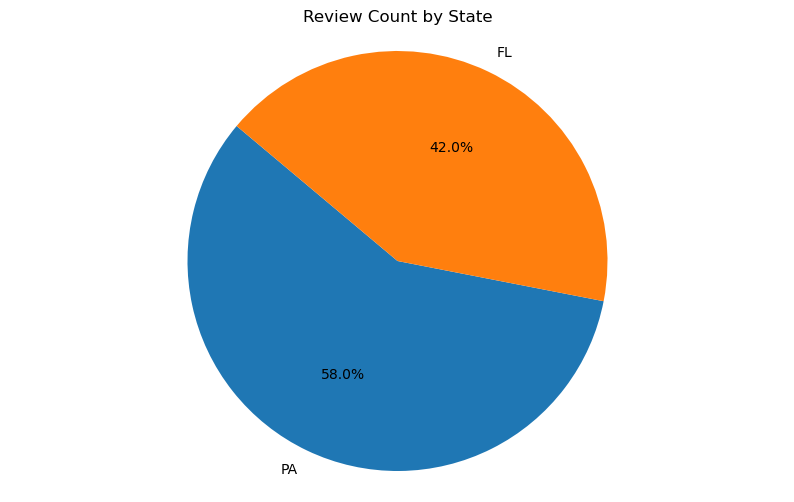

In [13]:
# Merge review_df with business_df to get state information
review_business = review_df.merge(business, on='business_id', how='inner')

# Get total review count
total_review_count = review_business["review_id"].nunique()

# Get review count by state
review_count_by_state = review_business['state'].value_counts()

# Print results
print("Total Review Count:", total_review_count)

# Plot the pie chart
plt.figure(figsize=(10, 6))
plt.pie(review_count_by_state, labels=review_count_by_state.index, autopct='%1.1f%%', startangle=140)
plt.title("Review Count by State")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### b) Total number of tokens:

In [14]:
# Tokenize and count words in each review
from nltk.tokenize import word_tokenize
total_tokens = sum(len(word_tokenize(text)) for text in review_business['text'].dropna())

print("Total Number of Tokens:", total_tokens)

Total Number of Tokens: 98334233


### c) Number of Unique words

In [15]:
# Tokenize all reviews and get unique words
all_words = set()  # Use a set to store unique words

for text in review_business['text'].dropna():
    tokens = word_tokenize(text.lower())  # Convert to lowercase for consistency
    all_words.update(tokens)

# Get the count of unique words
unique_word_count = len(all_words)
print("Number of Unique Words:", unique_word_count)

Number of Unique Words: 297193


### d) Average review Length

In [16]:
# Compute average word count per review using NLTK tokenizer
average_length = review_business['text'].dropna().apply(lambda x: len(word_tokenize(x))).mean()

print("Average Number of Words per Review:", average_length)

Average Number of Words per Review: 116.32974686090007


### e) Number of unique customers

In [17]:
# Merge business_review with user table to get only relevant users
review_business_user = review_business.merge(user_df, on='user_id', how='inner')

# Count unique customers
unique_customers = review_business_user["user_id"].nunique()
print("Number of Unique Customers:", unique_customers)

Number of Unique Customers: 351921


### f) Other key metrics

In [18]:
# Number of businesses
num_businesses = review_business_user['business_id'].nunique()

# Average stars per review
avg_stars = review_business_user['stars_x'].mean()

# Average votes per review (assuming columns: 'useful', 'funny', 'cool' for votes)
avg_votes = review_business_user[['useful_x', 'funny_x', 'cool_x']].sum(axis=1).mean()

# Print Summary
summary = pd.DataFrame({
    "Metric": ["Number of Businesses", "Avg Stars per Review", "Avg Votes per Review"],
    "Value": [num_businesses, avg_stars, avg_votes]
})

print(summary)

                 Metric        Value
0  Number of Businesses  8642.000000
1  Avg Stars per Review     3.848331
2  Avg Votes per Review     1.726402


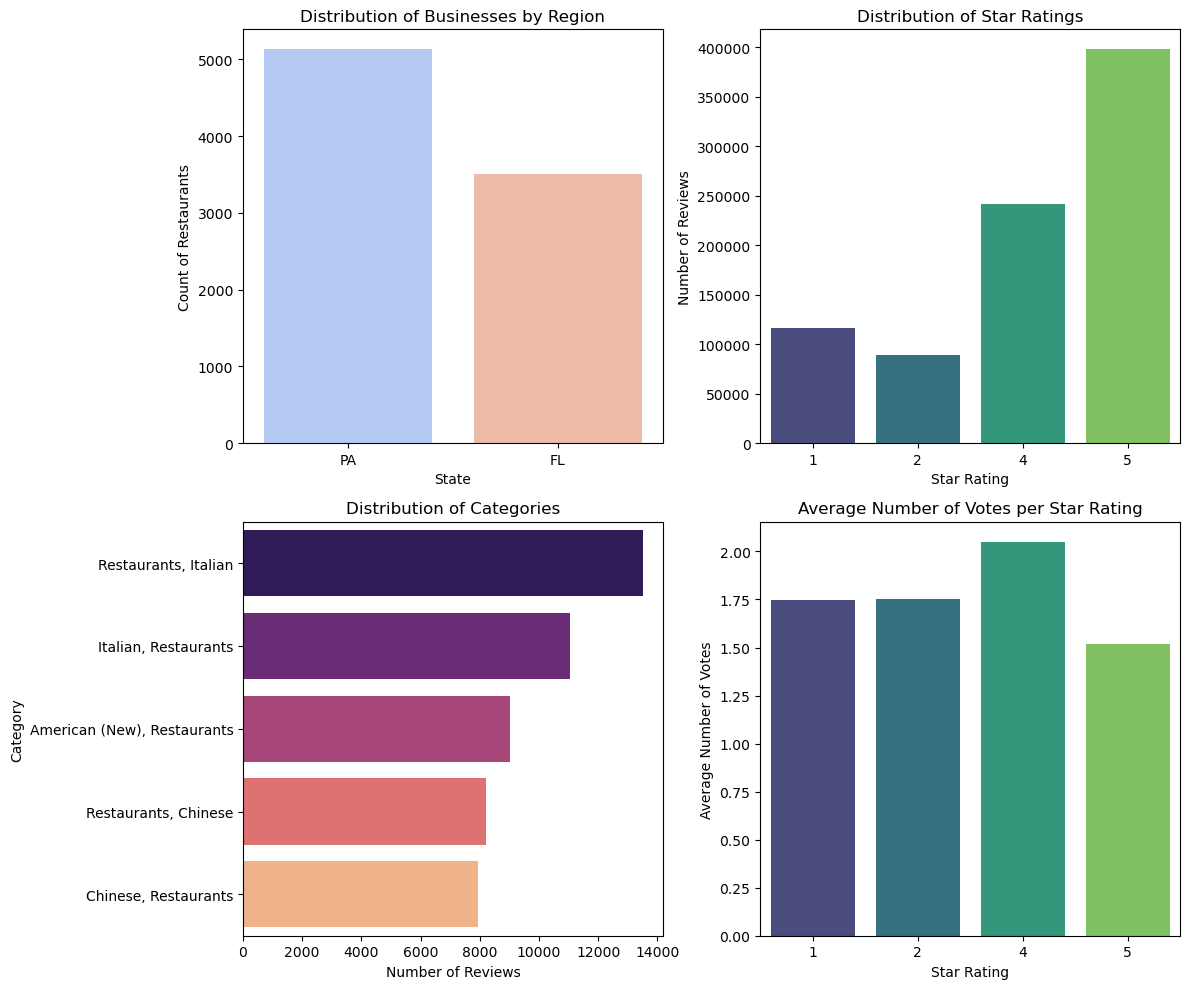

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Number of businesses per region
business_count_per_state = review_business_user.groupby('state')['business_id'].nunique().reset_index()
sns.barplot(x='state', y='business_id', data=business_count_per_state, order=business_count_per_state.sort_values('business_id', ascending=False)['state'], palette="coolwarm", ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Businesses by Region")
axes[0, 0].set_xlabel("State")
axes[0, 0].set_ylabel("Count of Restaurants")

# Distribution of reviews per star rating
sns.countplot(x=review_business_user['stars_x'], ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title("Distribution of Star Ratings")
axes[0, 1].set_xlabel("Star Rating")
axes[0, 1].set_ylabel("Number of Reviews")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0) 

# Fix Distribution of Categories
review_count_by_category = review_business_user['categories'].value_counts().head(5)  # Get top 20 categories
sns.barplot(x=review_count_by_category.values, y=review_count_by_category.index, palette="magma", ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Categories")
axes[1, 0].set_xlabel("Number of Reviews")
axes[1, 0].set_ylabel("Category")

# Average number of votes per star rating
review_business_user['total_votes'] = review_business_user[['useful_x', 'funny_x', 'cool_x']].sum(axis=1)
average_votes_per_star = review_business_user.groupby('stars_x')['total_votes'].mean().reset_index()
sns.barplot(x='stars_x', y='total_votes', data=average_votes_per_star, palette="viridis", ax=axes[1, 1])
axes[1, 1].set_title("Average Number of Votes per Star Rating")
axes[1, 1].set_xlabel("Star Rating")
axes[1, 1].set_ylabel("Average Number of Votes")

plt.tight_layout()
plt.show()

**A) Suitability of Selected Data**
The Yelp dataset is highly appropriate for this analysis because:
- It contains detailed customer reviews, star ratings, and business data, which are essential for understanding sentiment and its correlation with business success.
- It provides structured business information (location, category, etc.), allowing us to filter restaurants based on state and cuisine.
- The dataset includes both textual (reviews) and numerical (ratings, tips) data, enabling a comprehensive analysis of review impact on business performance.

**B) Sample Size Appropriateness**
- The Yelp dataset is extensive, but the appropriateness of the sample depends on data distribution.
- Since we are filtering for PA and FL and focusing on specific restaurant categories, we need to ensure:<br>
a) Sufficient number of reviews per restaurant for meaningful insights.<br>
b) A balanced distribution of positive and negative reviews to avoid skewed results.<br>

The Yelp dataset contains a total of 6,990,280 reviews. After applying our filtering conditions, we have selected 845,306 reviews, which accounts for approximately 15% of the total reviews. This serves as a strong and representative starting point, as we are focusing on only two states.

In addition to reviews, our filtered dataset includes:
- 379,191 users out of 1,987,897 total users, ensuring a substantial and diverse sample of customer interactions.
- 9,009 businesses from an initial 150,346, allowing us to analyze a meaningful subset of restaurants while maintaining statistical reliability.
- 6,441 categories out of 83,160, ensuring we capture a wide range of business types without unnecessary noise.


**C) Potential Bias in Data**
- Selection Bias: Yelp reviews are voluntary, meaning they might overrepresent extreme opinions (highly satisfied or dissatisfied customers).
- Geographical Bias: The analysis might be skewed if one region has significantly more reviews than another.
- Category Bias: Different cuisines may receive different types of feedback (e.g., Thai restaurants may get different review language than American ones).
- Tipping Bias: Not all customers tip, so tip-related insights may be based on a subset of users rather than the full dataset.

**D) Challenges in Processing Data**
- Text Cleaning: Reviews contain slang, emojis, abbreviations, and need preprocessing.
- Sentiment Detection Complexity: Star ratings do not always align with review sentiment (e.g., sarcastic reviews).
- Regional Comparison Complexity: Differences in cultural preferences and review styles between states must be accounted for.
- Handling Missing Data: Some businesses may lack sufficient review/tipping data, affecting analysis.

## Text Processing Techniques

In [20]:
!pip install wordcloud
!pip install textblob
import nltk
import string
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
!pip install scikit-learn==1.3.0 scipy==1.12.0 torch==2.3.0

  Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (547 kB)
  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)
  Using cached scikit_learn-1.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached torch-2.3.0-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
 

In [21]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
# Define stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [23]:
# Function for text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords & non-alphabetic tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)

In [24]:
# Apply preprocessing to review text
review_business['clean_text'] = review_business['text'].dropna().apply(preprocess_text)


In [25]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Filter for 1-star and 5-star reviews
one_star_reviews = review_business[review_business['stars_x'] == 1].copy()
five_star_reviews = review_business[review_business['stars_x'] == 5].copy()

# Apply text preprocessing
one_star_reviews['processed_text'] = one_star_reviews['text'].apply(preprocess_text)
five_star_reviews['processed_text'] = five_star_reviews['text'].apply(preprocess_text)

# Limit vocabulary to the most frequent 1000 words
vectorizer = CountVectorizer(max_features=1000)
one_star_matrix = vectorizer.fit_transform(one_star_reviews['processed_text'])
five_star_matrix = vectorizer.transform(five_star_reviews['processed_text'])

# Compute word frequency efficiently
one_star_word_counts = dict(zip(vectorizer.get_feature_names_out(), one_star_matrix.T.toarray().sum(axis=1)))
five_star_word_counts = dict(zip(vectorizer.get_feature_names_out(), five_star_matrix.T.toarray().sum(axis=1)))

# Get the top 25 most common words
one_star_common_words = sorted(one_star_word_counts.items(), key=lambda x: x[1], reverse=True)[:25]
five_star_common_words = sorted(five_star_word_counts.items(), key=lambda x: x[1], reverse=True)[:25]

# Print the results
print("Most Common Words in 1-Star Reviews:")
print(one_star_common_words)

print("\nMost Common Words in 5-Star Reviews:")
print(five_star_common_words)

Most Common Words in 1-Star Reviews:
[('food', 105077), ('place', 63139), ('time', 59309), ('order', 54743), ('service', 50793), ('one', 49025), ('back', 48659), ('like', 45737), ('would', 45212), ('get', 43739), ('ordered', 43704), ('table', 41878), ('never', 41732), ('restaurant', 40626), ('minute', 39263), ('go', 37641), ('good', 37523), ('came', 36202), ('even', 36174), ('said', 33156), ('got', 32752), ('asked', 30796), ('dont', 30280), ('didnt', 29822), ('drink', 28883)]

Most Common Words in 5-Star Reviews:
[('food', 274381), ('great', 251376), ('place', 213434), ('good', 171230), ('service', 135587), ('time', 126109), ('delicious', 114804), ('best', 103329), ('back', 103239), ('restaurant', 98357), ('amazing', 95374), ('one', 95013), ('go', 90285), ('also', 84897), ('like', 83824), ('love', 82578), ('get', 81803), ('menu', 79764), ('really', 76181), ('always', 74369), ('definitely', 71847), ('well', 70824), ('friendly', 68037), ('pizza', 66646), ('staff', 65782)]


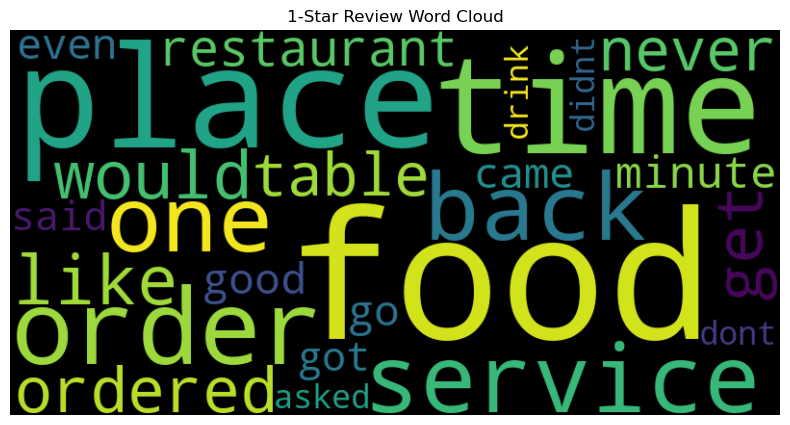

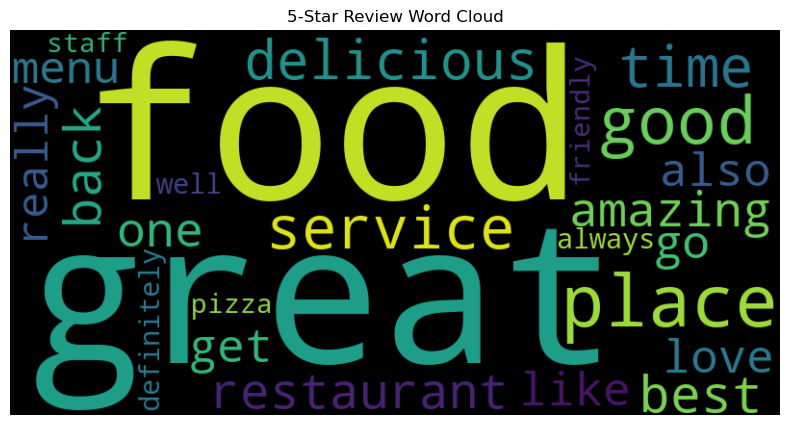

In [26]:
# Convert list of tuples to dictionary if necessary
one_star_common_words_dict = dict(one_star_common_words)
five_star_common_words_dict = dict(five_star_common_words)

# Generate word clouds
wordcloud_1_star = WordCloud(width=800, height=400).generate_from_frequencies(one_star_common_words_dict)
wordcloud_5_star = WordCloud(width=800, height=400).generate_from_frequencies(five_star_common_words_dict)

# Plot for 1-Star Review Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1_star, interpolation='bilinear')
plt.title("1-Star Review Word Cloud")
plt.axis('off')
plt.show()

# Plot for 5-Star Review Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_5_star, interpolation='bilinear')
plt.title("5-Star Review Word Cloud")
plt.axis('off')
plt.show()


In [27]:
# Word Frequency Analysis
word_freq = Counter(" ".join(review_business['clean_text']).split())
print("Most Common Words:", word_freq.most_common(20))

Most Common Words: [('food', 642925), ('good', 471682), ('place', 468669), ('great', 434399), ('time', 324905), ('service', 311558), ('like', 255549), ('one', 253865), ('back', 252850), ('restaurant', 232393), ('get', 228662), ('go', 216754), ('would', 208375), ('u', 200525), ('really', 199173), ('ordered', 198370), ('also', 185695), ('menu', 183444), ('delicious', 182536), ('order', 181865)]


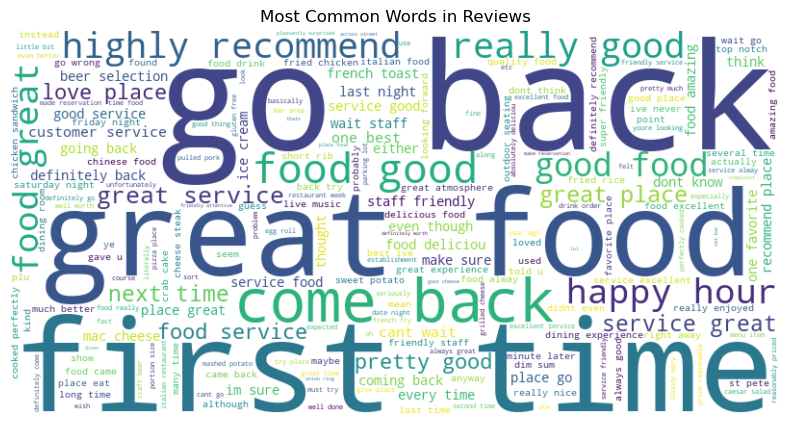

In [28]:
# Word Cloud Visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(review_business['clean_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Reviews")
plt.show()


In [29]:
# Bigram & Trigram Extraction
def extract_ngrams(text, n):
    words = text.split()
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

# Extract bigrams and trigrams
review_business['bigrams'] = review_business['clean_text'].apply(lambda x: extract_ngrams(x, 2))
review_business['trigrams'] = review_business['clean_text'].apply(lambda x: extract_ngrams(x, 3))


In [30]:
# Print sample results
print("Sample Cleaned Reviews:", review_business[['text', 'clean_text']].head(5))
print("Most Common Bigrams:", Counter([bigram for sublist in review_business['bigrams'] for bigram in sublist]).most_common(10))
print("Most Common Trigrams:", Counter([trigram for sublist in review_business['trigrams'] for trigram in sublist]).most_common(10))


Sample Cleaned Reviews:                                                 text  \
0  Amazingly amazing wings and homemade bleu chee...   
1  Good food--loved the gnocchi with marinara\nth...   
2  Great place for breakfast! I had the waffle, w...   
3  I recently had dinner here with my wife over t...   
4  First time there and it was excellent!!! It fe...   

                                          clean_text  
0  amazingly amazing wing homemade bleu cheese ri...  
1  good foodloved gnocchi marinara baked eggplant...  
2  great place breakfast waffle fluffy perfect ho...  
3  recently dinner wife weekend could pleased mea...  
4  first time excellent feel like entering someon...  
Most Common Bigrams: [('go back', 41842), ('first time', 38734), ('great food', 33564), ('come back', 32907), ('food good', 32008), ('really good', 31181), ('highly recommend', 31114), ('happy hour', 28982), ('food great', 27890), ('great service', 25704)]
Most Common Trigrams: [('wait go back', 7992), ('can

Most Common Words in Tips: [('great', 28337), ('food', 28334), ('good', 18982), ('service', 14468), ('place', 13213), ('best', 9910), ('love', 7130), ('get', 6583), ('amazing', 6120), ('delicious', 5890)]


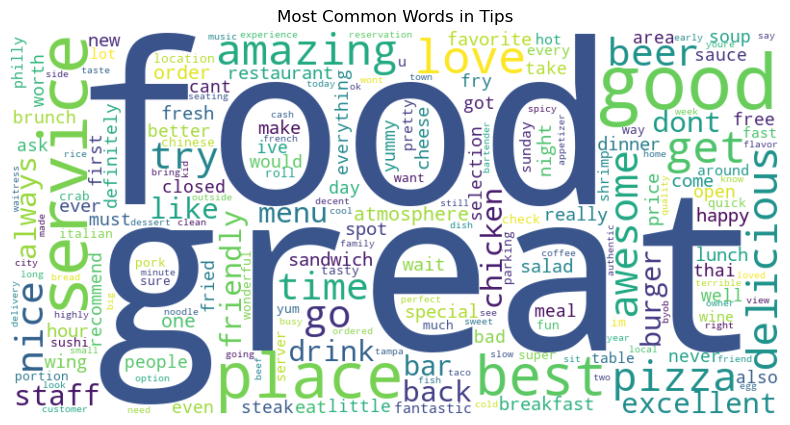

In [33]:
tip_df['text'] = tip_df['text'].astype(str)  # Convert all values to strings
# Step 1: Preprocess the Tips data
tip_df['clean_text'] = tip_df['text'].apply(preprocess_text)

# Step 2: Calculate sentiment scores for the tip text
#tip_df['sentiment'] = tip_df['clean_text'].apply(get_sentiment)

# Step 5: Find top 10 most frequent words in processed tip text
tip_word_counts = Counter(" ".join(tip_df['clean_text']).split())
print("Most Common Words in Tips:", tip_word_counts.most_common(10))

# Step 6: Generate Word Cloud for Tips
tip_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tip_word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(tip_wordcloud, interpolation='bilinear')
plt.title("Most Common Words in Tips")
plt.axis('off')
plt.show()

## Observations

**Common Words:** In 1-star reviews, words like "never", "didn't", and "food" suggest dissatisfaction, while 5-star reviews feature positive terms like "great", "delicious", and "friendly", reflecting overall satisfaction.

**Cleaned Text:** Preprocessing has successfully removed unnecessary words, leaving core terms that improve further analysis.

**Bigrams and Trigrams:** Phrases like "go back", "first time", and "food great service" indicate common experiences, both positive and negative, in customer feedback.

**Tips:** Words like "great", "food", and "service" dominate tips, reinforcing the importance of these factors in customer satisfaction.

## Topic Modeling for Tip file


Topic 1:
happy menu lunch place bar hour drink beer great good

Topic 2:
amazing staff friendly excellent love place good service great food

Topic 3:
wing fry amazing good delicious salad cheese try chicken best

Topic 4:
got place dont service free bad eat order burger pizza

Topic 5:
im sandwich like pork philly time place best make dont


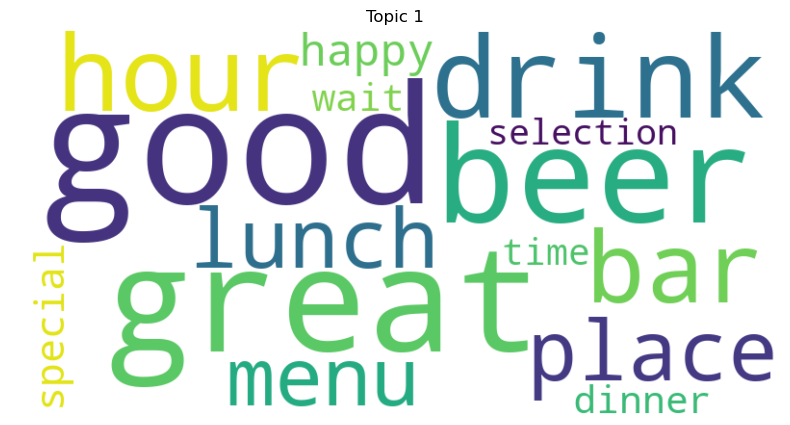

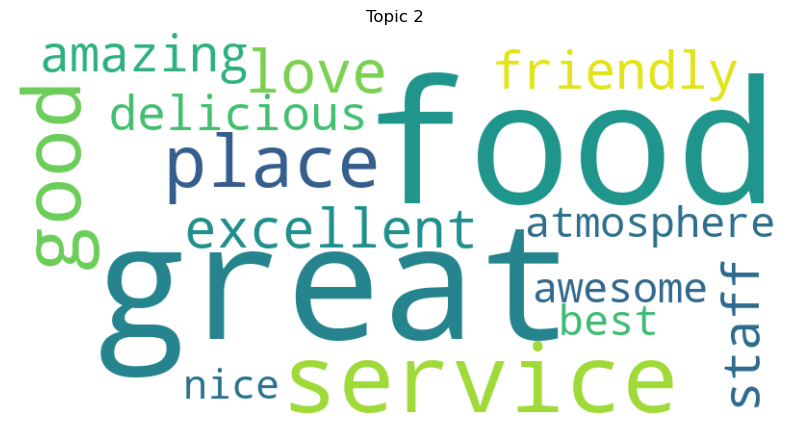

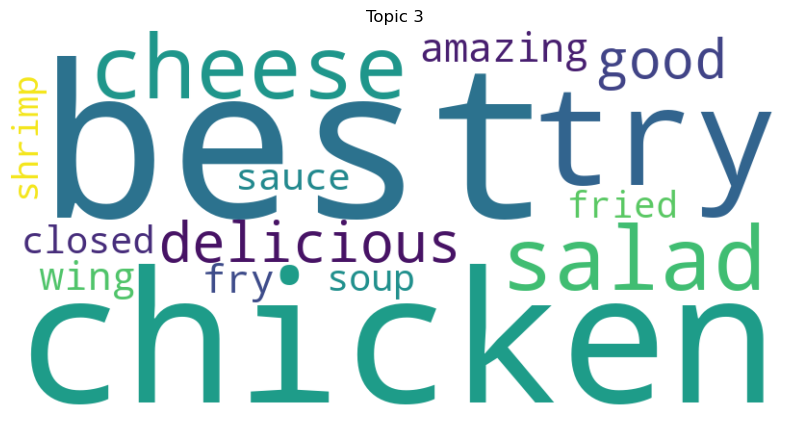

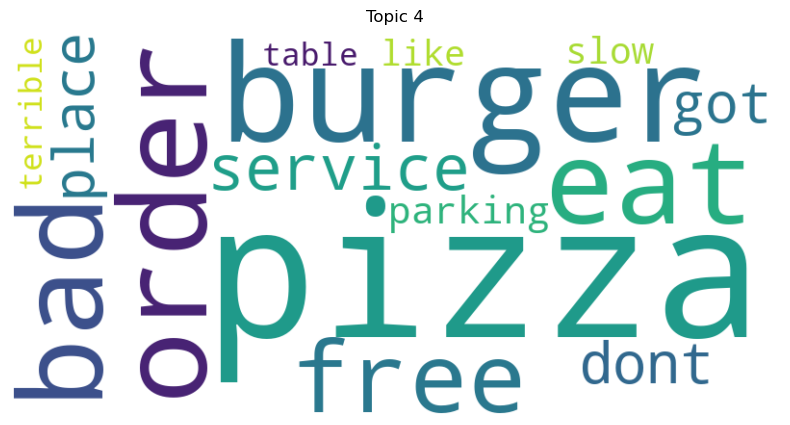

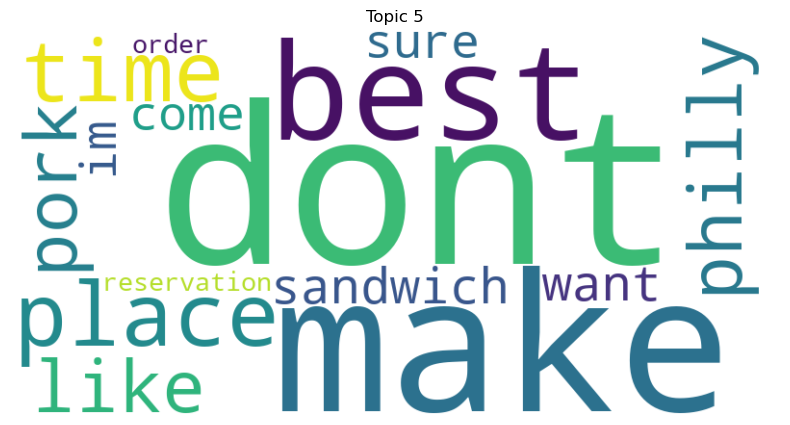

In [35]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# Convert text data into a document-term matrix
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(tip_df['clean_text'])

# Apply LDA for Topic Modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(dtm)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Function to display topics
def display_topics(model, feature_names, num_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-num_words:]]))

# Display top words for each topic
display_topics(lda, feature_names)

# Visualizing the Topics using WordCloud
for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    word_freqs = {feature_names[i]: topic[i] for i in topic.argsort()[-15:]}  # Get top words
    wordcloud.generate_from_frequencies(word_freqs)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()

## Topic Modeling for Review File


Topic 1:
amazing delicious beer time friendly service good place food great

Topic 2:
menu salad got food sauce delicious dish ordered chicken good

Topic 3:
food room time table night drink restaurant place like bar

Topic 4:
time fry sandwich cheese burger food like good place pizza

Topic 5:
server asked ordered came minute table service order time food


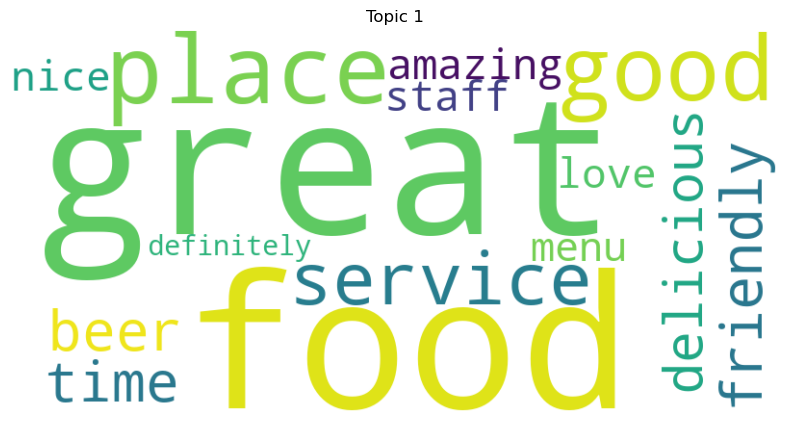

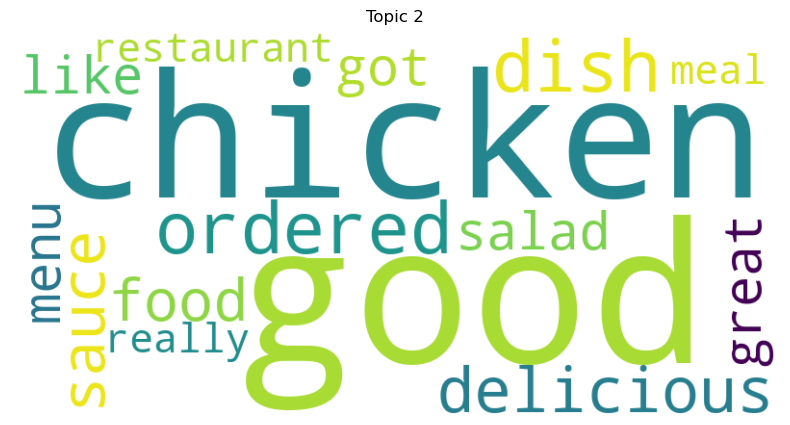

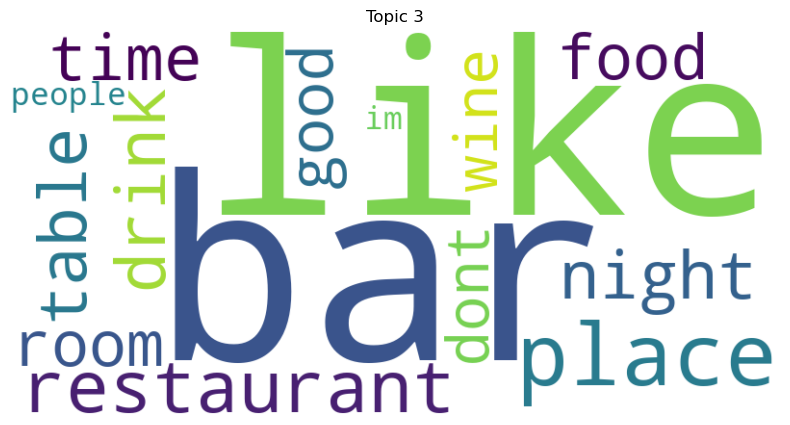

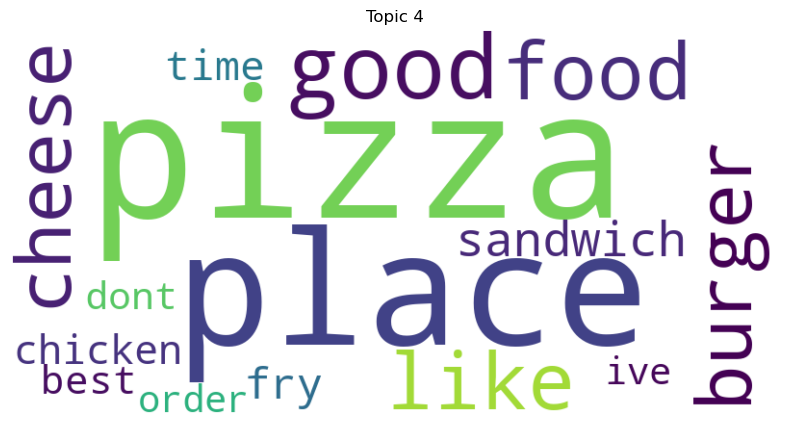

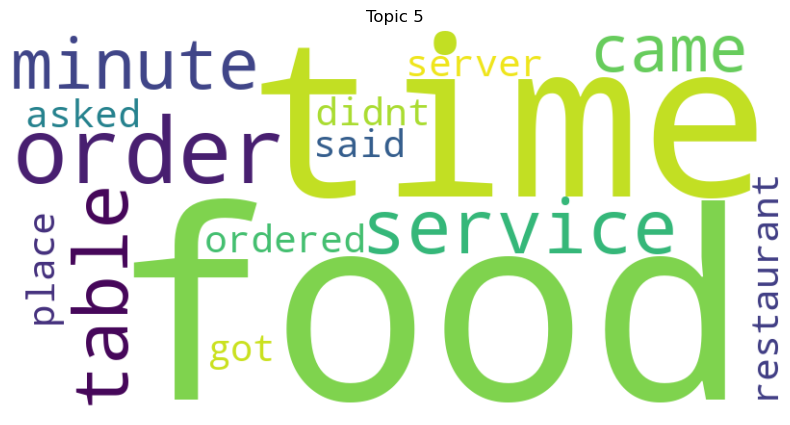

In [38]:
# Convert review text into a document-term matrix
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(review_business['clean_text'])  # Use review text instead of tip text

# Apply LDA for Topic Modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust number of topics as needed
lda.fit(dtm)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Function to display topics
def display_topics(model, feature_names, num_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-num_words:]]))

# Display top words for each topic in reviews
display_topics(lda, feature_names)

# Visualizing the Topics using WordCloud
for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    word_freqs = {feature_names[i]: topic[i] for i in topic.argsort()[-15:]}  # Get top words
    wordcloud.generate_from_frequencies(word_freqs)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()